# Dominant Direction SHAP Networks

This notebook implements dominant direction aggregation of SHAP values for clearest mechanistic interpretation.

**Approach:** For each feature/interaction, identify the dominant direction (positive or negative) based on cumulative absolute magnitude, then aggregate only values in that direction. This provides clear interpretation: each feature is either a risk factor or protective factor, not both.

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../data/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../data/shap_values.npy")
shap_interaction_values = np.load("../data/shap_interaction_values.npy")

## Build Dominant Direction SHAP Values (psi_1)

In [4]:
shap_values_clean = np.nan_to_num(shap_values)
n_features = shap_values_clean.shape[1]

# For each feature, determine dominant direction and filter
dominant_shap_values = np.zeros_like(shap_values_clean)
feature_directions = []

for feature_idx in range(n_features):
    feature_shap = shap_values_clean[:, feature_idx]
    
    # Calculate cumulative absolute magnitude in each direction
    positive_magnitude = np.sum(feature_shap[feature_shap > 0])
    negative_magnitude = np.sum(np.abs(feature_shap[feature_shap < 0]))
    
    # Determine dominant direction
    if positive_magnitude > negative_magnitude:
        # Keep only positive values
        dominant_shap_values[:, feature_idx] = np.where(
            feature_shap > 0, feature_shap, 0
        )
        direction = 'positive (risk factor)'
        dominance_ratio = positive_magnitude / (positive_magnitude + negative_magnitude) if (positive_magnitude + negative_magnitude) > 0 else 0
    else:
        # Keep only negative values
        dominant_shap_values[:, feature_idx] = np.where(
            feature_shap < 0, feature_shap, 0
        )
        direction = 'negative (protective)'
        dominance_ratio = negative_magnitude / (positive_magnitude + negative_magnitude) if (positive_magnitude + negative_magnitude) > 0 else 0
    
    feature_directions.append({
        'feature': X_shapley.columns[feature_idx],
        'direction': direction,
        'dominance_ratio': dominance_ratio,
        'positive_mag': positive_magnitude,
        'negative_mag': negative_magnitude
    })

# Build psi_1
sum_shap_values = np.sum(np.abs(dominant_shap_values), axis=(0, 1))
psi_1 = pd.DataFrame()
psi_1['value'] = np.sum(dominant_shap_values, axis=0) / sum_shap_values
psi_1.set_index(X_shapley.columns, inplace=True)

# Display feature directions
direction_df = pd.DataFrame(feature_directions)
direction_df = direction_df.sort_values('dominance_ratio', ascending=False)
print("Feature Directions (sorted by dominance):")
print(direction_df.head(20))

Feature Directions (sorted by dominance):
                                 feature               direction  \
12                     BUN_isTestnotdone   negative (protective)   
14                calcium_isUnacceptable   negative (protective)   
11                    BUN_isUnacceptable   negative (protective)   
37                  hematocrit_isMissing   negative (protective)   
61              urine_glucose_isVerydark   negative (protective)   
62                 urine_glucose_isTrace   negative (protective)   
74              uric_acid_isUnacceptable  positive (risk factor)   
52                 urine_albumin_is>=100   negative (protective)   
49                 cholesterol_isMissing  positive (risk factor)   
54                urine_albumin_is>=1000   negative (protective)   
53                 urine_albumin_is>=300   negative (protective)   
17             creatinine_isUnacceptable  positive (risk factor)   
39                 platelets_isIncreased   negative (protective)   
22    

## Build Dominant Direction Interaction Values (r_1)

In [5]:
# Remove diagonal
n_variables = shap_interaction_values.shape[1]
filtered_shap_interaction_values = np.nan_to_num(shap_interaction_values.copy())
idx_patients = np.repeat(np.arange(num_patients), n_variables)
idx_variables = np.tile(np.arange(n_variables), num_patients)
filtered_shap_interaction_values[idx_patients, idx_variables, idx_variables] = 0

# Build dominant direction interaction matrix
dominant_interaction_values = np.zeros_like(filtered_shap_interaction_values)
interaction_directions = []

for i in range(n_variables):
    for j in range(n_variables):
        if i == j:
            continue
        
        interaction = filtered_shap_interaction_values[:, i, j]
        
        # Calculate cumulative absolute magnitude in each direction
        positive_magnitude = np.sum(interaction[interaction > 0])
        negative_magnitude = np.sum(np.abs(interaction[interaction < 0]))
        
        # Determine dominant direction
        if positive_magnitude > negative_magnitude:
            dominant_interaction_values[:, i, j] = np.where(
                interaction > 0, interaction, 0
            )
            direction = 'positive'
        else:
            dominant_interaction_values[:, i, j] = np.where(
                interaction < 0, interaction, 0
            )
            direction = 'negative'
        
        total_magnitude = positive_magnitude + negative_magnitude
        if total_magnitude > 0:
            interaction_directions.append({
                'feature_i': X_shapley.columns[i],
                'feature_j': X_shapley.columns[j],
                'direction': direction,
                'total_magnitude': total_magnitude
            })

# Build r_1
sum_shap_interaction_values = np.sum(dominant_interaction_values, axis=(0, 1, 2))
cumulative_shap_interaction_values = np.sum(dominant_interaction_values, axis=0)

r_1 = pd.DataFrame(cumulative_shap_interaction_values / sum_shap_interaction_values)
r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
r_1.set_index(X_shapley.columns, inplace=True)

print(f"\nTotal interactions processed: {len(interaction_directions)}")


Total interactions processed: 2452


## Normalize Matrices

In [6]:
psi_2 = normalize_psi(psi_1)
r_2 = normalize_r(r_1)

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)


## Visualization

In [7]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.01
negative_alpha = 0.01
positive_beta = 0
negative_beta = 0

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(filter_edge)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adjacency = r.copy().applymap(lambda x: 1 if x != 0 else 0)


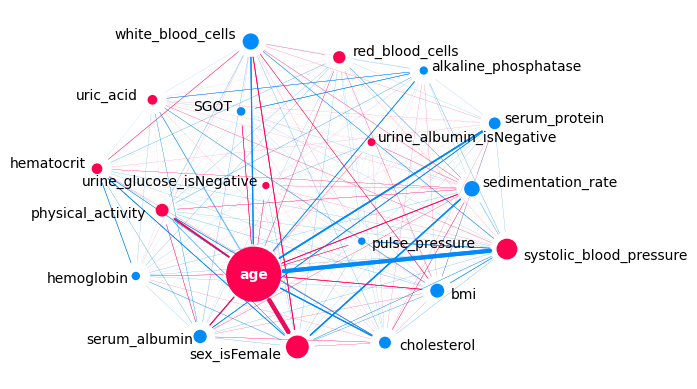

In [12]:
draw(
    psi=psi_2,
    r=r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)

## Feature Analysis: Risk vs Protective Factors

In [13]:
# Separate risk and protective features
risk_features = direction_df[direction_df['direction'] == 'positive (risk factor)'].copy()
protective_features = direction_df[direction_df['direction'] == 'negative (protective)'].copy()

# Add absolute importance from psi_1
risk_features['importance'] = risk_features['feature'].map(
    lambda x: psi_1.loc[x, 'value'] if x in psi_1.index else 0
)
protective_features['importance'] = protective_features['feature'].map(
    lambda x: abs(psi_1.loc[x, 'value']) if x in psi_1.index else 0
)

print("\n=== TOP RISK FACTORS ===")
print(risk_features.nlargest(10, 'importance')[['feature', 'importance', 'dominance_ratio']])

print("\n=== TOP PROTECTIVE FACTORS ===")
print(protective_features.nlargest(10, 'importance')[['feature', 'importance', 'dominance_ratio']])


=== TOP RISK FACTORS ===
                 feature  importance  dominance_ratio
30     white_blood_cells    0.075523         0.561033
71    sedimentation_rate    0.068407         0.698854
78                   bmi    0.054397         0.605062
3          serum_albumin    0.048761         0.546210
48           cholesterol    0.038267         0.693098
26         serum_protein    0.037250         0.613681
7                   SGOT    0.017847         0.702601
33            hemoglobin    0.017044         0.733150
4   alkaline_phosphatase    0.016355         0.546148
77        pulse_pressure    0.012728         0.652849

=== TOP PROTECTIVE FACTORS ===
                     feature  importance  dominance_ratio
1                        age    1.000000         0.679937
0               sex_isFemale    0.158418         0.568705
76   systolic_blood_pressure    0.130581         0.602054
2          physical_activity    0.045480         0.524260
27           red_blood_cells    0.041409         0.886066


## Direction Dominance Statistics


Dominance Ratio Statistics:
Mean dominance ratio: 0.722
Median dominance ratio: 0.713
Min dominance ratio: 0.000
Max dominance ratio: 1.000

Features with >80% dominance: 33 / 80


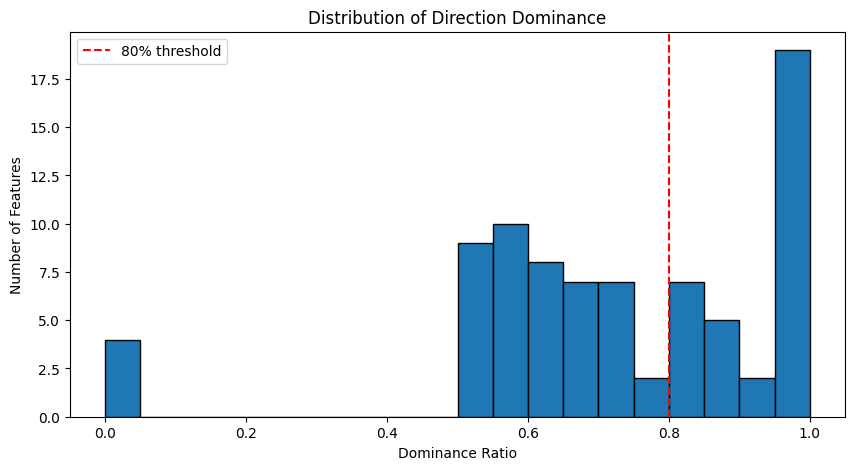

In [14]:
# Analyze dominance ratios
print("\nDominance Ratio Statistics:")
print(f"Mean dominance ratio: {direction_df['dominance_ratio'].mean():.3f}")
print(f"Median dominance ratio: {direction_df['dominance_ratio'].median():.3f}")
print(f"Min dominance ratio: {direction_df['dominance_ratio'].min():.3f}")
print(f"Max dominance ratio: {direction_df['dominance_ratio'].max():.3f}")

# Count features with strong dominance (>80%)
strong_dominance = direction_df[direction_df['dominance_ratio'] > 0.8]
print(f"\nFeatures with >80% dominance: {len(strong_dominance)} / {len(direction_df)}")

# Histogram of dominance ratios
plt.figure(figsize=(10, 5))
plt.hist(direction_df['dominance_ratio'], bins=20, edgecolor='black')
plt.xlabel('Dominance Ratio')
plt.ylabel('Number of Features')
plt.title('Distribution of Direction Dominance')
plt.axvline(0.8, color='r', linestyle='--', label='80% threshold')
plt.legend()
plt.show()

## Features with Mixed Effects (Low Dominance)

These features have competing positive and negative effects

In [15]:
# Features with weak dominance (near 50/50 split)
mixed_features = direction_df[
    (direction_df['dominance_ratio'] >= 0.4) & 
    (direction_df['dominance_ratio'] <= 0.6)
].sort_values('dominance_ratio')

print(f"\nFeatures with mixed effects (40-60% dominance): {len(mixed_features)}")
if len(mixed_features) > 0:
    print(mixed_features[['feature', 'direction', 'dominance_ratio', 'positive_mag', 'negative_mag']].head(10))


Features with mixed effects (40-60% dominance): 19
                     feature               direction  dominance_ratio  \
73                 uric_acid   negative (protective)         0.515229   
60      urine_glucose_isDark   negative (protective)         0.519192   
2          physical_activity   negative (protective)         0.524260   
50  urine_albumin_isNegative   negative (protective)         0.528934   
46                 basophils  positive (risk factor)         0.539047   
57  urine_glucose_isNegative   negative (protective)         0.542651   
35                hematocrit   negative (protective)         0.544621   
4       alkaline_phosphatase  positive (risk factor)         0.546148   
3              serum_albumin  positive (risk factor)         0.546210   
42     segmented_neutrophils   negative (protective)         0.553002   

    positive_mag  negative_mag  
73      8.052879      8.558841  
60      1.811085      1.955670  
2      14.724790     16.226532  
50      4.61